In [2]:
# Import python libraries
#
import importlib
import pickle
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import torch.nn as nn

# Go one directory back, because all imports are done
# relative to the root of the project.
#
project_root = '..'
if 'change_directory_to_root' not in globals():
    change_directory_to_root = True
    os.chdir(project_root)

# Imports own modules.
#
import scripts.Visualization as Visualization
import scripts.ModelTrainer as ModelTrainer
import scripts.Utils as utils
import scripts.Simulation_config as Simulation_config
from scripts.Simulation_config import *
import scripts.Model as Model
import scripts.ModelAdapter as ModelAdapter


/home/molu/miniconda3/envs/xlstm/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
No CUDA runtime is found, using CUDA_HOME='/home/molu/miniconda3/envs/xlstm'


In [2]:
# Store specific predictions, for the paper 'use case' section.
#
execute_this_cell = False
if execute_this_cell:
    importlib.reload(Model)
    importlib.reload(Simulation_config)
    importlib.reload(utils)
    importlib.reload(ModelTrainer)

    # Define a specific configuration
    #
    myConfig = Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
                    NrOfComunities._20, TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT)

    modelTrainer = ModelTrainer.ModelTrainer()
    loadProfiles, weatherData, public_holidays_timestamps = modelTrainer.load_data(myConfig)
    modelAdapter = ModelAdapter.ModelAdapter(public_holidays_timestamps, 
                                                train_size = myConfig.trainingHistory,
                                                test_size = modelTrainer.test_set_size_days, 
                                                )
    community_id = 0  # chose one of many energy communites
    X, Y = modelAdapter.transformData(loadProfiles[community_id], weatherData)
    path_to_trained_parameters = 'scripts/outputs/all_trained_models.pth'
    num_of_features = X['train'].shape[2]
    P_el_predicted = modelAdapter.deNormalizeY(Y['test']).flatten().unsqueeze(0)

    # Store the predicted power profiles
    #
    for model_type in Simulation_config.UsedModels.ALL:
        test_profile = f"scripts/outputs/file_{community_id}.pkl"
        my_Model = utils.Deserialize.get_trained_model(path_to_trained_parameters, model_type, test_profile, 
                                                        myConfig, num_of_features, modelAdapter)
        Y_pred = torch.Tensor(modelAdapter.deNormalizeY(my_Model.predict(X['test'], Y['test'])).flatten())
        P_el_predicted = torch.cat([P_el_predicted, Y_pred.unsqueeze(0)], dim=0)    

    startdate = modelAdapter.getStartDateFromIndex('test', 0)
    timestamp = utils.Serialize.get_act_timestamp()
    file_path = f"scripts/outputs/example_predictions{timestamp}.pkl"
    with open(file_path, 'wb') as file:
        pickle.dump((P_el_predicted, startdate), file)

    print(P_el_predicted.shape)
    print(startdate)


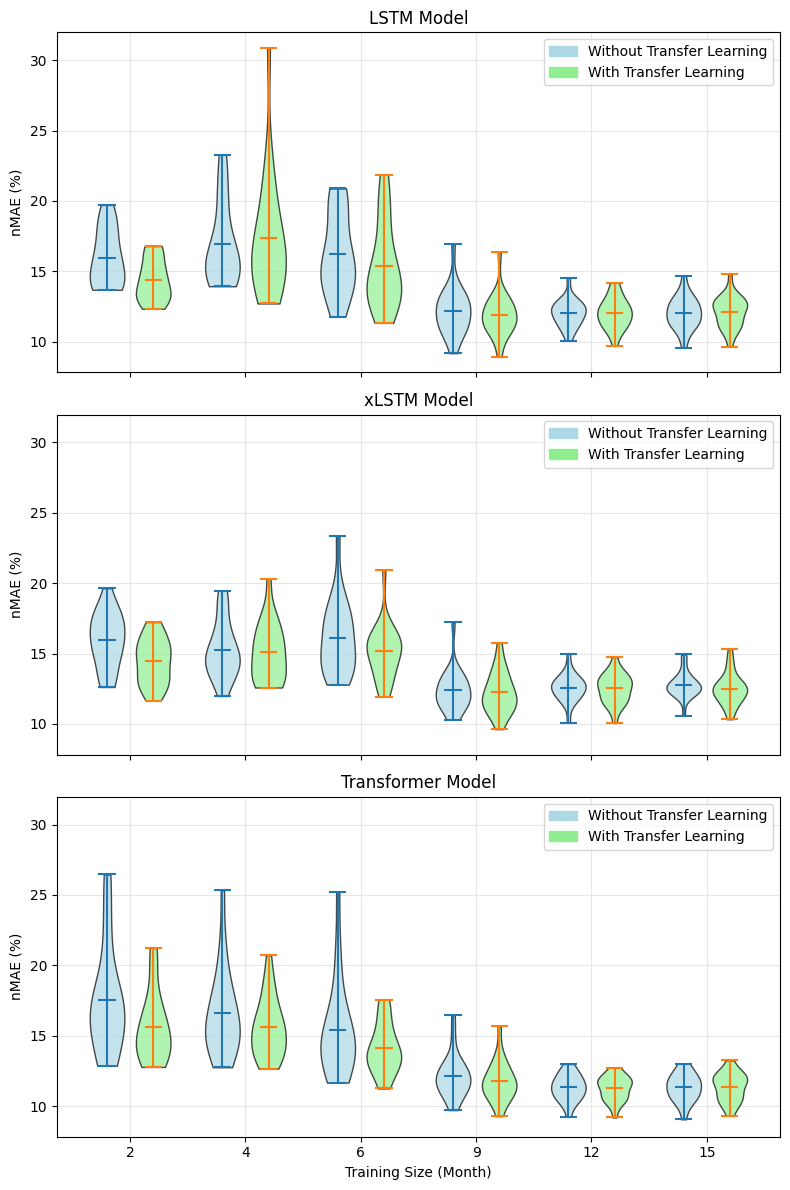

In [15]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

configs = [
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._2_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._4_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT), 
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._15_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),       
    
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._2_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._4_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),  
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._15_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
]

# Constants and Configuration
models = ('LSTM', 'xLSTM', 'Transformer', )
configs_with_transfer = configs[0:6]
configs_without_transfer = configs[6:12]
training_sizes = ['2', '4', '6', '9', '12', '15']

# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, expected_configs, available_configs):
    myList = []
    for expected_config in expected_configs:
        for available_config in available_configs:
            if expected_config == available_config:            
                myList.append(result_dict[available_config][model])
    
    assert len(myList) == len(expected_configs), f"Not all configs found: {len(myList)} != {len(expected_configs)}."
    
    return myList

# Prepare data for each model and transfer condition
data_with_transfer = {model: get_full_data_list(model, configs_with_transfer, result_dict) for model in models}
data_without_transfer = {model: get_full_data_list(model, configs_without_transfer, result_dict) for model in models}

# Creating subplots for violin plots
fig, axes = plt.subplots(len(models), 1, figsize=(8, 12), sharex=True, sharey=True)

# Define legend patches for the legend
legend_patches = [
    Patch(color="lightblue", label="Without Transfer Learning"),
    Patch(color="lightgreen", label="With Transfer Learning")
]

# Plot each model's data on a separate subplot
for idx, model in enumerate(models):
    ax = axes[idx]
    
    # Get data for each training size
    data_without = data_without_transfer[model]
    data_with = data_with_transfer[model]
    
    # Plot violin plots for without and with transfer data
    # Offset positions slightly for comparison
    positions = np.array(range(len(training_sizes))) * 2.0    
    quantiles = [[0.25, 0.75] for _ in data_with]
    
    # Without Transfer Learning violins
    violins_without = ax.violinplot(data_without, positions=positions - 0.4, widths=0.6, 
                                    showmeans=True, showextrema=True, showmedians=False)       #quantiles=quantiles
    # With Transfer Learning violins
    violins_with = ax.violinplot(data_with, positions=positions + 0.4, widths=0.6, 
                                 showmeans=True, showextrema=True, showmedians=False)

    # Set custom colors for the violins by modifying each PolyCollection
    for pc in violins_without['bodies']:
        pc.set_facecolor("lightblue")
        pc.set_edgecolor("black")
        pc.set_alpha(0.7)
    for pc in violins_with['bodies']:
        pc.set_facecolor("lightgreen")
        pc.set_edgecolor("black")
        pc.set_alpha(0.7)    
    
    # Labels and title
    ax.set_ylabel('nMAE (%)')
    ax.set_title(f"{model} Model")
    # ax.text(0.4, 0.9, f"{model} Model", transform=ax.transAxes, fontsize=16, ha="center", va="center")
    ax.set_xticks(positions)
    ax.set_xticklabels(training_sizes)
    ax.set_axisbelow(True)
    ax.grid(True, color="0.9")
    
    # Add legend to each subplot
    ax.legend(handles=legend_patches, loc="upper right")
    
    # Set x-axis label for the last plot
    # ax.set_xlabel('Training Size (Month)')
    
axes[-1].set_xlabel('Training Size (Month)')
plt.tight_layout()
plt.savefig("scripts/outputs/figs/transfer_learning_over_train_size.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()


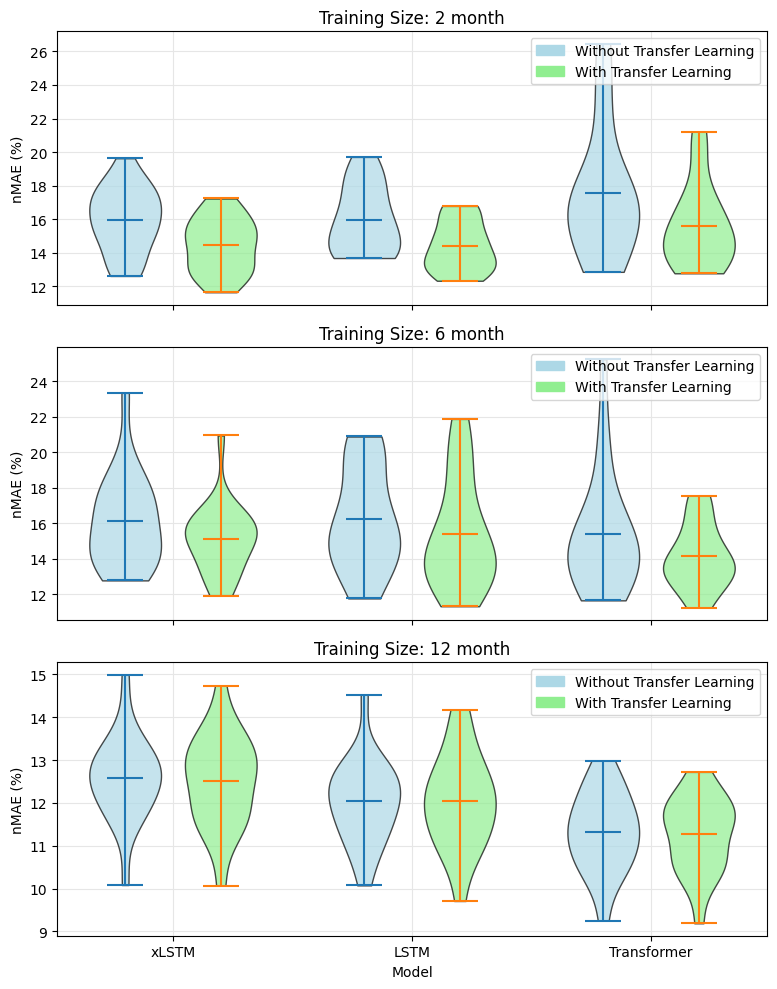

In [16]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

configs = [
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._2_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),   
    
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._2_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
]

# Constants and Configuration
models = ('xLSTM', 'LSTM', 'Transformer', )
configs_with_transfer = configs[:3]
configs_without_transfer = configs[3:]
training_sizes = ['2','6','12']

# Constants and Configuration
# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, expected_configs, available_configs):
    myList = []
    for expected_config in expected_configs:
        for available_config in available_configs:
            if expected_config == available_config:            
                myList.append(result_dict[available_config][model])
    
    assert len(myList) == len(expected_configs), f"Not all configs found: {len(myList)} != {len(expected_configs)}."
    
    return myList

# Prepare data for each model and transfer condition
data_with_transfer = {model: get_full_data_list(model, configs_with_transfer, result_dict) for model in models}
data_without_transfer = {model: get_full_data_list(model, configs_without_transfer, result_dict) for model in models}

# Transpose data for each household size
data_with = {}
data_without = {}
for i, size in enumerate(training_sizes):
    data_with[size] = [data_with_transfer[model][i] for model in models]
    data_without[size] = [data_without_transfer[model][i] for model in models]

# Creating subplots for each household size
fig, axes = plt.subplots(len(configs_with_transfer), 1, figsize=(8, 10), sharex=True, sharey=False)

# Define legend patches for the legend
legend_patches = [
    Patch(color="lightblue", label="Without Transfer Learning"),
    Patch(color="lightgreen", label="With Transfer Learning")
]

# Plot each household size's data on a separate subplot
for idx, (size, data) in enumerate(data_with.items()):
    
    ax = axes[idx]

    # Plot violin plot
    positions = np.array(range(len(models))) * 2.0    

    # Without Transfer Learning violins
    violins_without = ax.violinplot(data_without[size], positions=positions - 0.4, widths=0.6, 
                                    showmeans=True, showextrema=True, showmedians=False)       #quantiles=quantiles
    # With Transfer Learning violins
    violins_with = ax.violinplot(data_with[size], positions=positions + 0.4, widths=0.6, 
                                    showmeans=True, showextrema=True, showmedians=False)
    
    # Set custom colors for the violins by modifying each PolyCollection
    for pc in violins_without['bodies']:
        pc.set_facecolor("lightblue")
        pc.set_edgecolor("black")
        pc.set_alpha(0.7)
    for pc in violins_with['bodies']:
        pc.set_facecolor("lightgreen")
        pc.set_edgecolor("black")
        pc.set_alpha(0.7)
    
    # Add legend to each subplot
    ax.legend(handles=legend_patches, loc="upper right")

    # Labels and title
    ax.set_ylabel('nMAE (%)')
#     ax.text(0.5, 0.9, f"Training Size: {size} month", transform=ax.transAxes, fontsize=12, ha="center", va="center")
    ax.set_title(f"Training Size: {size} month")
    ax.set_xticks(positions)
    ax.set_xticklabels(models)
    ax.set_axisbelow(True)
    ax.grid(True, color="0.9")

ax.set_xlabel('Model')
# axes[0].set_ylim(None, 32)
# axes[1].set_ylim(None, 30)
# axes[2].set_ylim(None, 17)

plt.tight_layout()
plt.savefig("scripts/outputs/figs/transfer_learning_over_train_size.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()


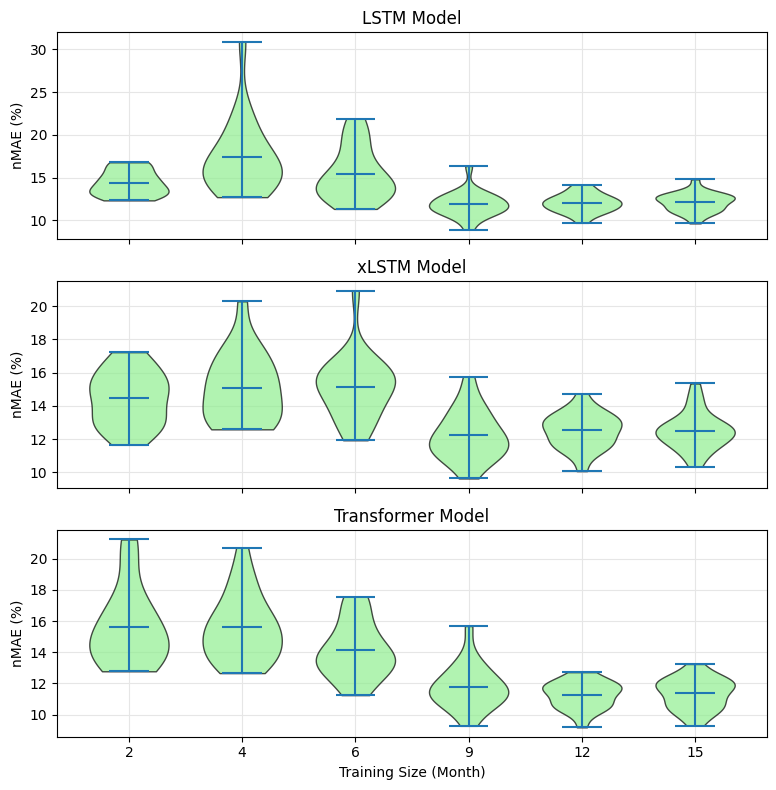

In [17]:
# Compare the effect of the model sizes
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

configs = [
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._2_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._4_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
        TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._15_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
]

# Constants and Configuration
models = ('LSTM', 'xLSTM', 'Transformer', )
training_sizes = ['2', '4', '6', '9', '12', '15']

# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, expected_configs, available_configs):
    myList = []
    for expected_config in expected_configs:
        for available_config in available_configs:
            if expected_config == available_config:            
                myList.append(result_dict[available_config][model])
    
    assert len(myList) == len(expected_configs), f"Not all configs found: {len(myList)} != {len(expected_configs)}."
    
    return myList

# Prepare data for each model
data_per_model = {model: get_full_data_list(model, configs, result_dict) for model in models}

# Creating subplots for violin plots
fig, axes = plt.subplots(len(models), 1, figsize=(8, 8), sharex=True, sharey=False)

# Plot each model's data on a separate subplot
for idx, model in enumerate(models):
    ax = axes[idx]
    
    # Get data for each training size
    data = data_per_model[model]
    
    # Plot the violins
    positions = np.array(range(len(training_sizes))) * 2.0    
    violins = ax.violinplot(data, positions=positions, widths=1.4,
                                    showmeans=True, showextrema=True, showmedians=False)
    
    for pc in violins['bodies']:
        pc.set_facecolor("lightgreen")
        pc.set_edgecolor("black")
        pc.set_alpha(0.7)
        
    # Labels and title
    ax.set_ylabel('nMAE (%)')
    ax.set_title(f"{model} Model")
    # ax.text(0.4, 0.9, f"{model} Model", transform=ax.transAxes, fontsize=16, ha="center", va="center")
    ax.set_xticks(positions)
    ax.set_xticklabels(training_sizes)
    ax.set_axisbelow(True)
    ax.grid(True, color="0.9")

axes[-1].set_xlabel('Training Size (Month)')
plt.tight_layout()
plt.savefig("scripts/outputs/figs/Error_over_train_size.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()


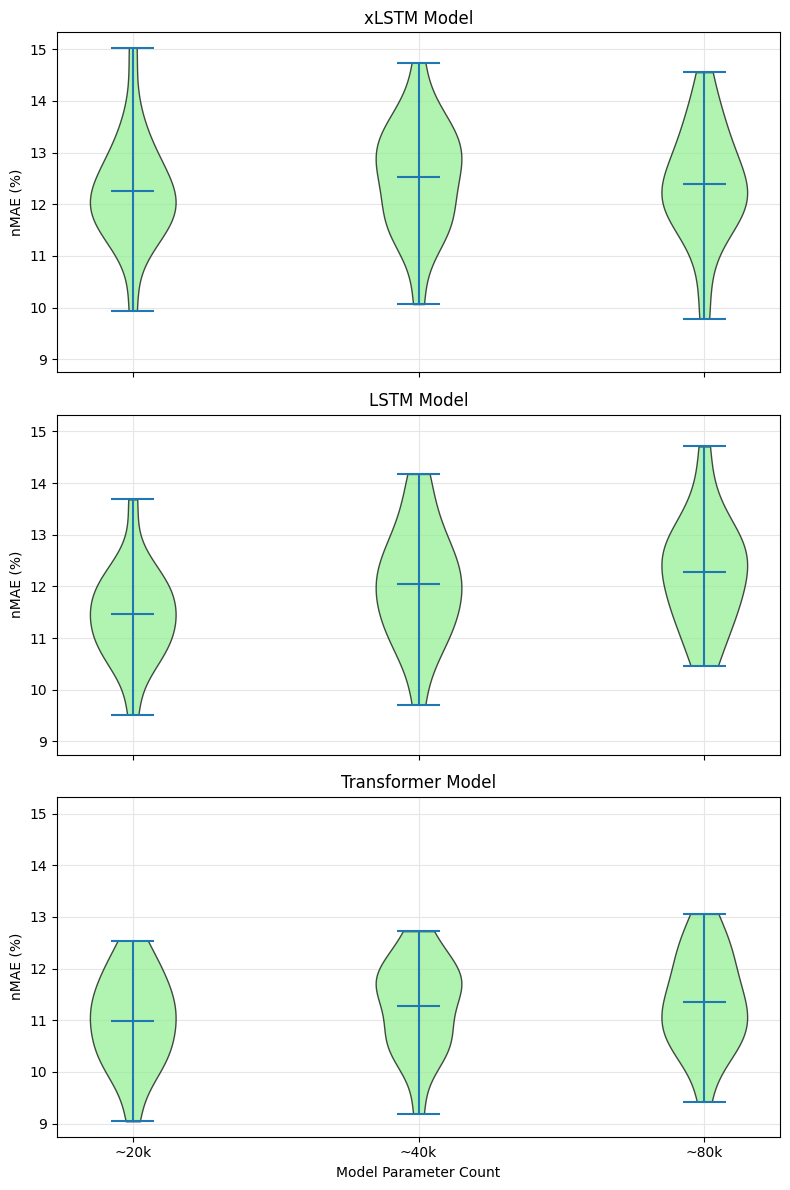

In [7]:
# Compare the effect of the model sizes
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

configs = [
    Config_of_one_run(ModelSize.SMALL, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.LARGE, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
]

# Constants and Configuration
models = ('xLSTM', 'LSTM', 'Transformer', )
training_sizes = ['~20k', '~40k', '~80k']

# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, expected_configs, available_configs):
    myList = []
    for expected_config in expected_configs:
        for available_config in available_configs:
            if expected_config == available_config:            
                myList.append(result_dict[available_config][model])
    
    assert len(myList) == len(expected_configs), f"Not all configs found: {len(myList)} != {len(expected_configs)}."
    
    return myList

# Prepare data for each model
data_per_model = {model: get_full_data_list(model, configs, result_dict) for model in models}

# Creating subplots for violin plots
fig, axes = plt.subplots(len(models), 1, figsize=(8, 12), sharex=True, sharey=True)

# Plot each model's data on a separate subplot
for idx, model in enumerate(models):
    ax = axes[idx]
    
    # Get data for each training size
    data = data_per_model[model]
    
    # Plot the violins
    positions = np.array(range(len(training_sizes))) * 2.0    
    violins = ax.violinplot(data, positions=positions, widths=0.6, 
                                    showmeans=True, showextrema=True, showmedians=False)
    
    for pc in violins['bodies']:
        pc.set_facecolor("lightgreen")
        pc.set_edgecolor("black")
        pc.set_alpha(0.7)
        
    # Labels and title
    ax.set_ylabel('nMAE (%)')
    ax.set_title(f"{model} Model")
    # ax.text(0.4, 0.9, f"{model} Model", transform=ax.transAxes, fontsize=16, ha="center", va="center")
    ax.set_xticks(positions)
    ax.set_xticklabels(training_sizes)
    ax.set_axisbelow(True)
    ax.grid(True, color="0.9")    
    
axes[-1].set_xlabel('Model Parameter Count')
plt.tight_layout()
plt.savefig("scripts/outputs/figs/performance_over_model_size.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()


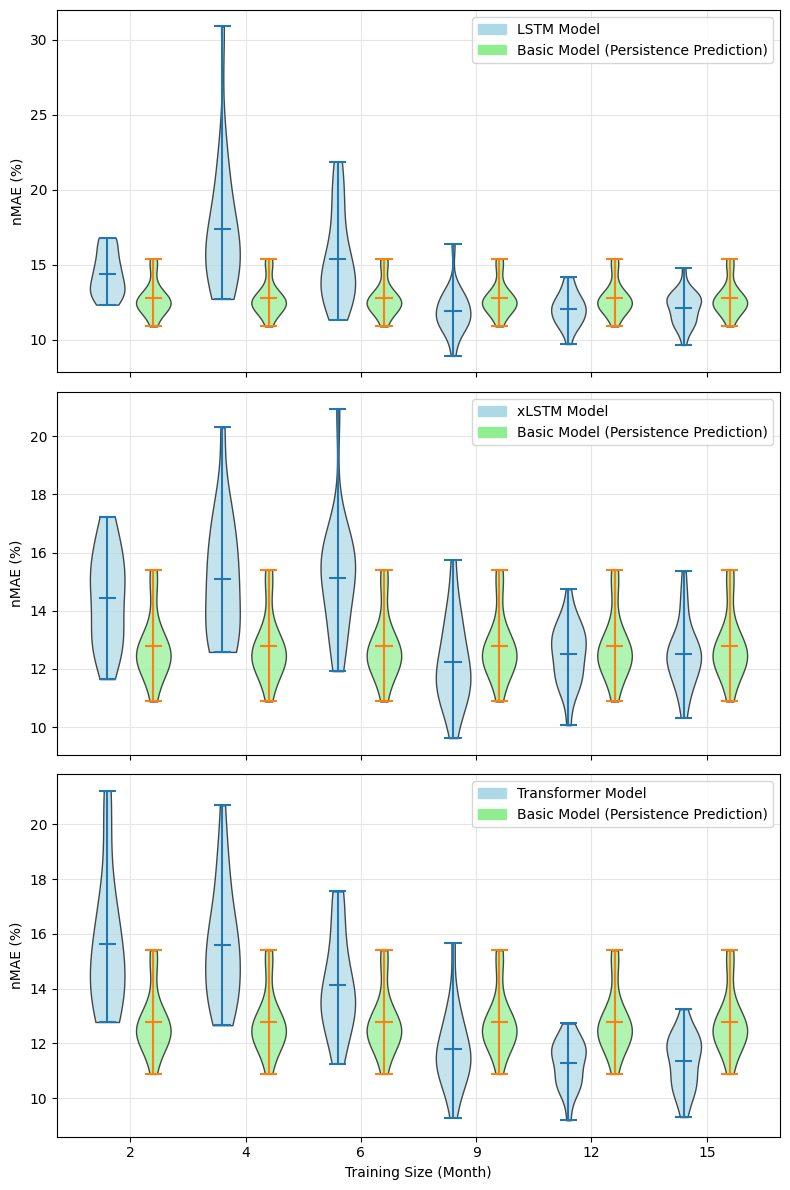

In [8]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

configs = [
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._2_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._4_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT), 
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._15_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),       
]

# Constants and Configuration
machine_learning_models = ('LSTM', 'xLSTM', 'Transformer', )
basic_model = 'PersistencePrediction'
training_sizes = ['2', '4', '6', '9', '12', '15']

# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, expected_configs, available_configs):
    myList = []
    for expected_config in expected_configs:
        for available_config in available_configs:
            if expected_config == available_config:            
                myList.append(result_dict[available_config][model])
    
    assert len(myList) == len(expected_configs), f"Not all configs found: {len(myList)} != {len(expected_configs)}."
    
    return myList

# Prepare data for each model and transfer condition
data_with_ML_models = {model: get_full_data_list(model, configs, result_dict) for model in machine_learning_models}
data_with_basic_model = get_full_data_list(basic_model, configs, result_dict)

# Creating subplots for violin plots
fig, axes = plt.subplots(len(machine_learning_models), 1, figsize=(8, 12), sharex=True, sharey=False)

# Plot each model's data on a separate subplot
for idx, model in enumerate(machine_learning_models):
    ax = axes[idx]
    
    # Get data for each training size
    data_with_ML_model = data_with_ML_models[model]
        
    # Without Transfer Learning violins
    positions = np.array(range(len(training_sizes))) * 2.0   
    violins_without = ax.violinplot(data_with_ML_model, positions=positions - 0.4, widths=0.6, 
                                    showmeans=True, showextrema=True, showmedians=False) 
    # With Transfer Learning violins
    violins_with = ax.violinplot(data_with_basic_model, positions=positions + 0.4, widths=0.6, 
                                 showmeans=True, showextrema=True, showmedians=False)

    # Set custom colors for the violins by modifying each PolyCollection
    for pc in violins_without['bodies']:
        pc.set_facecolor("lightblue")
        pc.set_edgecolor("black")
        pc.set_alpha(0.7)
    for pc in violins_with['bodies']:
        pc.set_facecolor("lightgreen")
        pc.set_edgecolor("black")
        pc.set_alpha(0.7)
    
    # Labels and title
    ax.set_ylabel('nMAE (%)')
    # ax.set_title(f"{model} Model")
    # ax.text(0.4, 0.9, f"{model} Model", transform=ax.transAxes, fontsize=16, ha="center", va="center")
    ax.set_xticks(positions)
    ax.set_xticklabels(training_sizes)
    ax.set_axisbelow(True)
    ax.grid(True, color="0.9")
    
    # Add legend to each subplot
    legend_patches = [
        Patch(color="lightblue", label=f"{model} Model"),
        Patch(color="lightgreen", label="Basic Model (Persistence Prediction)")
    ]
    ax.legend(handles=legend_patches, loc="upper right")
    
    # Set x-axis label for the last plot
    # ax.set_xlabel('Training Size (Month)')
    
axes[-1].set_xlabel('Training Size (Month)')
plt.tight_layout()
plt.savefig("scripts/outputs/figs/ML_model_vs_persistence_prediction.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()


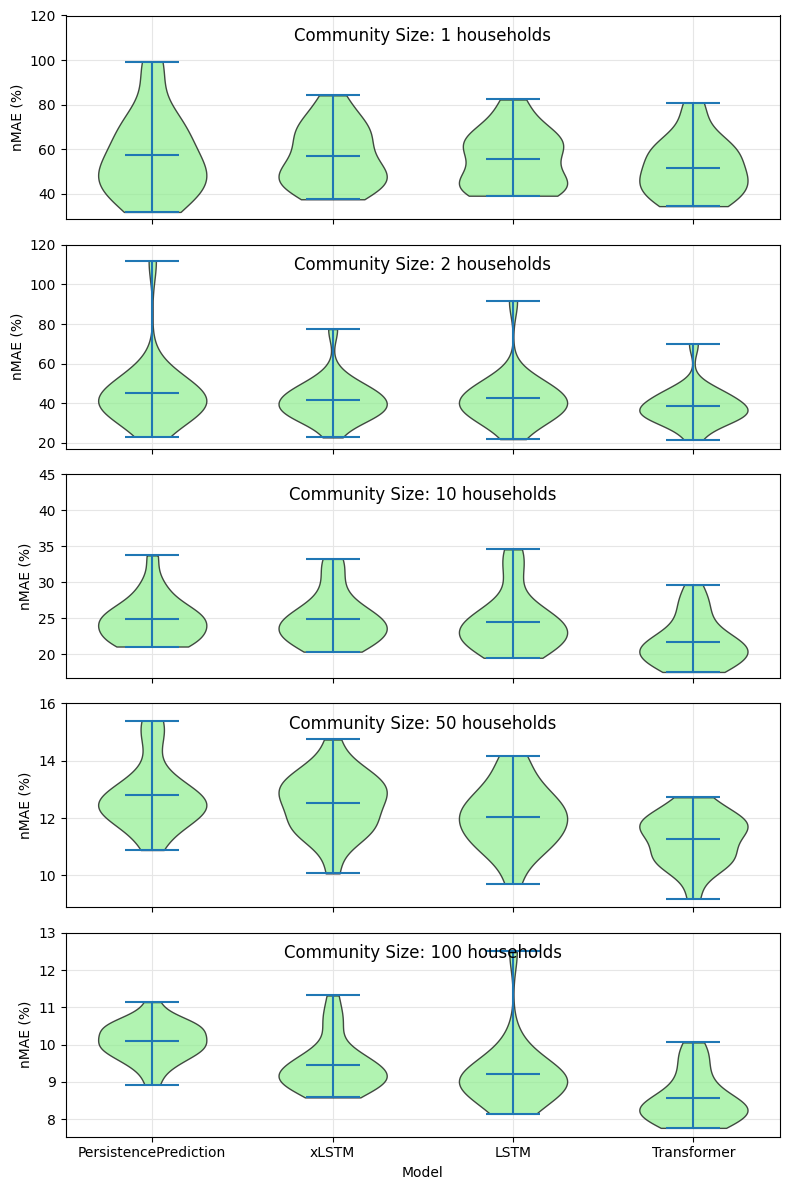

In [9]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

configs = [
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._1_HOUSEHOLD, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._2_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._10_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._100_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    ]

# Constants and Configuration
models = ('PersistencePrediction', 'xLSTM', 'LSTM', 'Transformer', )
household_sizes = ['1', '2', '10', '50', '100']

# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, expected_configs, available_configs):
    myList = []
    for expected_config in expected_configs:
        for available_config in available_configs:
            if expected_config == available_config:            
                myList.append(result_dict[available_config][model])
    
    assert len(myList) == len(expected_configs), f"Not all configs found: {len(myList)} != {len(expected_configs)}."
    
    return myList

# Prepare data for each model
full_data_list = {model: get_full_data_list(model, configs, result_dict) for model in models}

# Transpose data for each household size
data_by_household_size = {}
for i, size in enumerate(household_sizes):
    data_by_household_size[size] = [full_data_list[model][i] for model in models]

# Creating subplots for each household size
fig, axes = plt.subplots(len(household_sizes), 1, figsize=(8, 12), sharex=True, sharey=False)

# Plot each household size's data on a separate subplot
for idx, (size, data) in enumerate(data_by_household_size.items()):
    ax = axes[idx]
    
    # Plot violin plot
    positions = np.array(range(len(models)))
    violins = ax.violinplot(data, positions=positions, widths=0.6, 
                            showmeans=True, showextrema=True, showmedians=False)
    
    for pc in violins['bodies']:
        pc.set_facecolor("lightgreen")
        pc.set_edgecolor("black")
        pc.set_alpha(0.7)
        
    # Labels and title
    ax.set_ylabel('nMAE (%)')
    ax.text(0.5, 0.9, f"Community Size: {size} households", transform=ax.transAxes, fontsize=12, ha="center", va="center")
    ax.set_xticks(positions)
    ax.set_xticklabels(models)
    ax.set_axisbelow(True)
    ax.grid(True, color="0.9")
    
    # Set x-axis label for the last plot
    if idx == len(household_sizes) - 1:
        ax.set_xlabel('Model')

axes[0].set_ylim(None, 120)
axes[1].set_ylim(None, 120)
axes[2].set_ylim(None, 45)
axes[3].set_ylim(None, 16)
axes[4].set_ylim(None, 13)
plt.tight_layout()
plt.savefig("scripts/outputs/figs/error_over_community_size.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()


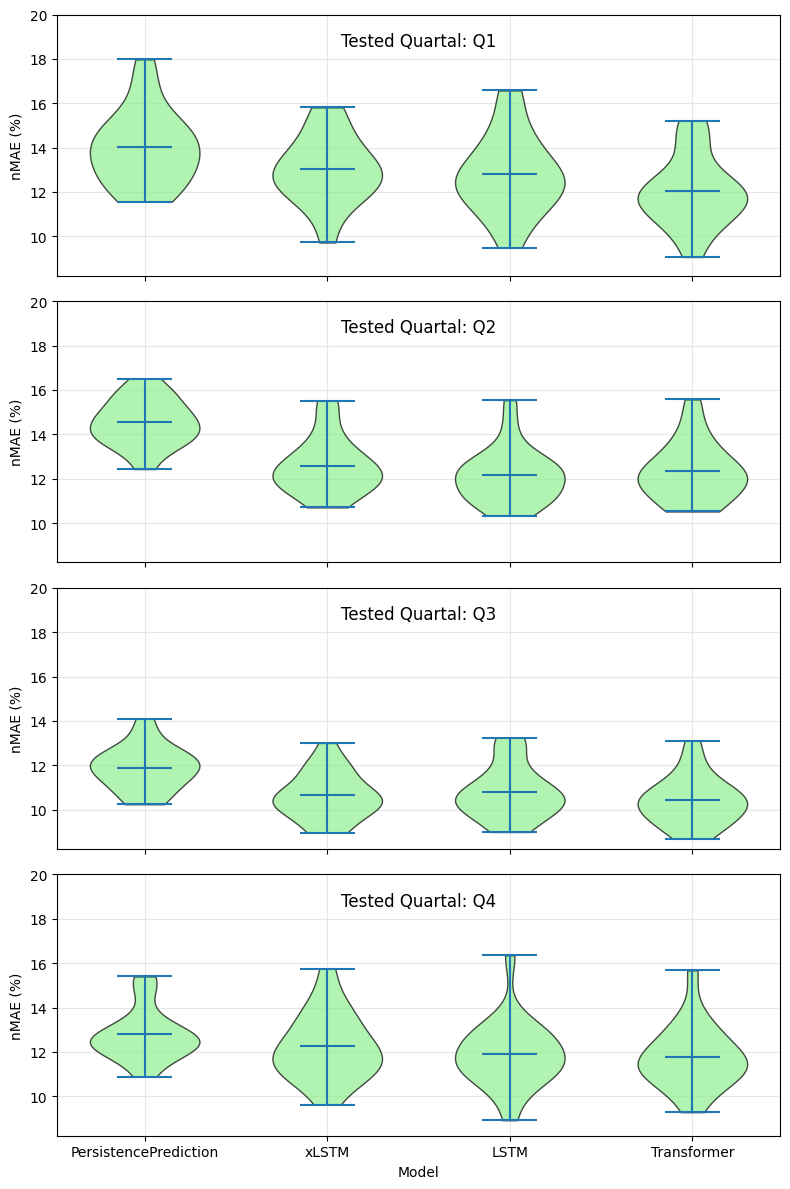

In [10]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

# Define, which configurations to print
# 
configs = [
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._0_MONTH, TestSize._3_MONTH, TrainingFuture._9_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._3_MONTH, TestSize._3_MONTH, TrainingFuture._6_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._3_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    ]
models = ('PersistencePrediction', 'xLSTM', 'LSTM', 'Transformer', )
tested_quartals = ['Q1', 'Q2', 'Q3', 'Q4']

# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, expected_configs, available_configs):
    myList = []
    for expected_config in expected_configs:
        for available_config in available_configs:
            if expected_config == available_config:            
                myList.append(result_dict[available_config][model])
    
    assert len(myList) == len(expected_configs), f"Not all configs found: {len(myList)} != {len(expected_configs)}."
    
    return myList

# Prepare data for each model
full_data_list = {model: get_full_data_list(model, configs, result_dict) for model in models}

# Transpose data
data_by_quartal = {}
for i, quartal in enumerate(tested_quartals):
    data_by_quartal[quartal] = [full_data_list[model][i] for model in models]

# Creating subplots
fig, axes = plt.subplots(len(tested_quartals), 1, figsize=(8, 12), sharex=True, sharey=True)

# Plot each quartal's data on a separate subplot
for idx, (quartal, data) in enumerate(data_by_quartal.items()):
    ax = axes[idx]
    
    # Plot violin plot
    positions = np.array(range(len(models)))
    violins = ax.violinplot(data, positions=positions, widths=0.6, 
                            showmeans=True, showextrema=True, showmedians=False)
    
    for pc in violins['bodies']:
        pc.set_facecolor("lightgreen")
        pc.set_edgecolor("black")
        pc.set_alpha(0.7)
        
    # Labels and title
    ax.set_ylabel('nMAE (%)')
    ax.text(0.5, 0.9, f"Tested Quartal: {quartal}", transform=ax.transAxes, fontsize=12, ha="center", va="center")
    ax.set_xticks(positions)
    ax.set_xticklabels(models)
    ax.set_axisbelow(True)
    ax.grid(True, color="0.9")
    
    # Set x-axis label for the last plot
    if idx == len(tested_quartals) - 1:
        ax.set_xlabel('Model')

axes[0].set_ylim(None, 20)
axes[1].set_ylim(None, 20)
axes[2].set_ylim(None, 20)
axes[3].set_ylim(None, 20)
plt.tight_layout()
plt.savefig("scripts/outputs/figs/error_over_tested_quartals.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()


In [ ]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)

result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

printed_configs = [

    # Vary the model sizes
    Config_of_one_run(ModelSize.SMALL, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.LARGE, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),

    # Vary the community sizes
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._1_HOUSEHOLD, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._2_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._10_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._100_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),

   # Vary the train set size
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._2_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._4_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._15_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    
   # Vary the tested quartals
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._3_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._3_MONTH, TestSize._3_MONTH, TrainingFuture._6_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._0_MONTH, TestSize._3_MONTH, TrainingFuture._9_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    
    # Without transfer learning:
    #
    
    # Vary the train set size
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._2_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._4_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._6_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._9_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._15_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT),
]

# Create Table "with Transfer Learning"
config_names = ['Small', 'Medium (Baseline)', 'Large', 
                '1', '2', '10', '50 (Baseline)', '100',
                '2 mo', '4 mo', '6 mo', '9 mo', '12 mo (Baseline)', '15 mo',
                'Quartal 1', 'Quartal 2', 'Quartal 3', 'Quartal 4 (Baseline)',
                ]
config_groups = [('Model Size', 3), '-', '-', 
                ('Aggregation', 4), '-', '-', '-', '-',
                ('Training Size', 4), '-', '-', '-', '-', '-',
                ('Testset (2013)', 3), '-', '-', '-',
                ]
configs_with_transfer_learning = printed_configs[:len(config_names)]
assert len(config_names) == len(config_groups) == len(configs_with_transfer_learning), \
        f"Unexpected list length: {len(config_names)} != {len(config_groups)} != {len(configs_with_transfer_learning)}"
utils.Evaluate_Models.print_latex_table(result_dict, configs_with_transfer_learning, config_groups, config_names)

# Create Table "withou Transfer Learning"
configs_without_transfer_learning = printed_configs[len(config_names):]
config_names = config_names[8:14]
config_groups = config_groups[8:14]
assert len(config_names) == len(config_groups) == len(configs_without_transfer_learning), \
        f"Unexpected list length: {len(config_names)} != {len(config_groups)} != {len(configs_without_transfer_learning)}"
utils.Evaluate_Models.print_latex_table(result_dict, configs_without_transfer_learning, config_groups, config_names)


\hline
\multirow{3}{*}{\textbf{Model Size}} 
    & Small & 22.31 (1.63) & 14.57 (1.25) & 12.79 (1.13) & 12.25 (1.02) & 11.46 (0.87) & \textbf{10.99} (0.86) \\ 
    & Medium (Baseline) & 22.31 (1.63) & 14.57 (1.25) & 12.79 (1.13) & 12.52 (1.04) & 12.05 (1.08) & \textbf{11.28} (0.86) \\ 
    & Large & 22.31 (1.63) & 14.57 (1.25) & 12.79 (1.13) & 12.39 (1.06) & 12.29 (1.01) & \textbf{11.36} (0.91) \\ 
\hline
\multirow{4}{*}{\textbf{Aggregation}} 
    & 1 & 100.45 (41.53) & 68.44 (18.69) & 57.25 (17.94) & 56.79 (13.16) & 55.61 (12.61) & \textbf{51.74} (12.61) \\ 
    & 2 & 67.25 (44.36) & 49.40 (16.30) & 44.98 (17.17) & 41.79 (10.81) & 42.51 (13.47) & \textbf{38.60} (9.52) \\ 
    & 10 & 34.96 (5.96) & 28.50 (4.10) & 24.86 (3.13) & 24.90 (3.47) & 24.50 (3.99) & \textbf{21.75} (3.28) \\ 
    & 50 (Baseline) & 22.31 (1.63) & 14.57 (1.25) & 12.79 (1.13) & 12.52 (1.04) & 12.05 (1.08) & \textbf{11.28} (0.86) \\ 
    & 100 & 20.96 (1.14) & 11.36 (0.77) & 10.10 (0.49) & 9.45 (0.68) & 9.20 (0.89) 

startdate = 2013-10-01 00:00:00+00:00
nMAE = 6.5% of community 0 on test day 3.
nMAE = 20.7% of community 0 on test day 85.
torch.Size([1, 92])


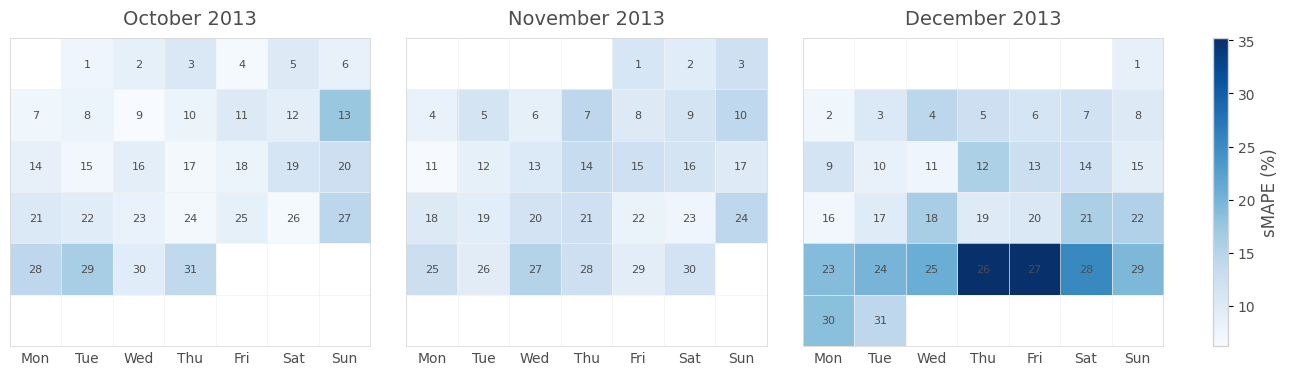

In [7]:
# Create Calendar Plot
#

importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)

# Get specific results
#
path_to_trained_parameters = 'scripts/outputs/all_trained_models.pth'
myConfig = Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
                NrOfComunities._20, TrainingHistory._12_MONTH, TestSize._3_MONTH, TrainingFuture._0_MONTH, DevSize._2_MONTH, UsedModels.ALL, Epochs.DEFAULT)
model_type = 'Transformer'

modelTrainer = ModelTrainer.ModelTrainer()
loadProfiles, weatherData, public_holidays_timestamps = modelTrainer.load_data(myConfig)
modelAdapter = ModelAdapter.ModelAdapter(
                        public_holidays_timestamps,
                        trainHistory = myConfig.trainingHistory,
                        testSize = myConfig.testSize,
                        trainFuture = myConfig.trainingFuture,
                        devSize = myConfig.devSize, 
                        )

# Do Predictions
#
nMAE_values = None
# for community_id in range(Simulation_config.NrOfComunities._20):
for community_id in range(1):
    X, Y = modelAdapter.transformData(loadProfiles[community_id], weatherData)
    P_el_predicted = modelAdapter.deNormalizeY(Y['test']).flatten().unsqueeze(0)
    test_profile = f"scripts/outputs/file_{community_id}.pkl"
    num_of_features = X['test'].shape[2]
    my_Model = utils.Deserialize.get_trained_model(path_to_trained_parameters, model_type, test_profile, 
                                                   myConfig, num_of_features, modelAdapter)
    Y_pred = modelAdapter.deNormalizeY(my_Model.predict(X['test'])).squeeze()
    Y_real = modelAdapter.deNormalizeY(Y['test']).squeeze()
    loss_fn = nn.L1Loss(reduction='none')
    assert type(loss_fn) == type(my_Model.loss_fn), "Different loss function then in the model chosen!"
    nMAE = (loss_fn(Y_pred, Y_real).mean(dim=1)) / torch.mean(Y_real)
    nMAE = nMAE.unsqueeze(0)
    nMAE *= 100    # Convert to %
    if nMAE_values == None:
        nMAE_values = torch.zeros((0, Y_pred.shape[0]))
    nMAE_values = torch.cat([nMAE_values, nMAE], dim=0)
    
startdate = modelAdapter.getStartDateFromIndex('test', 0)
print(f"startdate = {startdate}")

# Print daily nMAE results of chosen community
#
community_id = 0
test_day_nrs = [3, 85]
for test_day_nr in test_day_nrs:
    print(f"nMAE = {nMAE_values[community_id, test_day_nr].item():.1f}% " \
          f"of community {community_id} on test day {test_day_nr}.")
    
# Average over the different commnities
#
daily_values = nMAE_values.mean(dim=0)
print(nMAE_values.shape)

# Create plot
#
utils.Evaluate_Models.create_calendar_plot(startdate, daily_values)

